In [54]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt
import matplotlib.gridspec as gridspec

D2R = (np.pi/180.0)
R2D = 1.0/D2R
from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles, read_damp
from mpl_toolkits.mplot3d import Axes3D

from mpl_toolkits.axes_grid1 import make_axes_locatable


#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


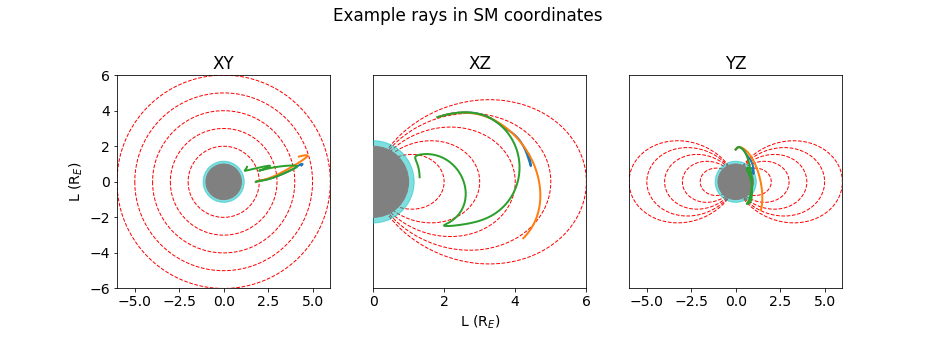

In [71]:
# Load n' plot the Ngo files:
project_root = os.getcwd();
ray_out_dir = os.path.join(project_root, "test_outputs");

# Load all the rayfiles in the output directory
d = os.listdir(ray_out_dir)
file_titles = [x[:-4] for x in d if x.endswith('.ray')]

raylist = []
damplist= []

for r in file_titles:
    raylist += read_rayfile(os.path.join(ray_out_dir,r + '.ray'))
    damplist+= read_damp(os.path.join(ray_out_dir,r + '.damp'))



# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 12  # width in inches
fig_height = 4      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

R_E = 6371e3
H_IONO=1000e3

flashtime = dt.datetime(2010,1,1,0,0,0)

# Put the rays into a friendly system (and so we can use coordinate transforms)
rays = []
for r in raylist:
    tmp_coords = coord.Coords(list(zip(r['pos'].x, r['pos'].y, r['pos'].z)),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    
    # Convert to whatever output coordinate system you'd like to plot!
    # Here's how to switch to Cartesian magnetic dipole.
#     tmp_coords = tmp_coords.convert('MAG','car')

    tmp_coords.sim_time = r['time']
    rays.append(tmp_coords)

psize = 6                     # plot size in earth radii
L_shells = [2, 3, 4, 5, 6]    # Field lines to draw

fig, ax = plt.subplots(1,3)

# Plot the earth
for i in [0, 1, 2]:
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='c',alpha=0.5, zorder=99)
    ax[i].add_patch(earth)   
    ax[i].add_patch(iono)
    
    
# Plot the fieldlines (dipole model; could use something more complex)
for L in L_shells:
    # Plot dipole field lines for both profile views
    lam = np.linspace(-80,80,181)
    L_r = L*pow(np.cos(lam*D2R),2)
    Lx  = L_r*np.cos(lam*D2R)
    Ly  = L_r*np.sin(lam*D2R)
    ax[1].plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line
    ax[2].plot(Lx,Ly,color='r',linewidth=1,linestyle='dashed')   # Field line
    ax[2].plot(-Lx,Ly,color='r',linewidth=1,linestyle='dashed')  # Field line (other side)
    
    # Plot equatorial extent for the top-down view
    lam = np.linspace(-180,180,181)
    Lx2  = L*np.cos(lam*D2R)
    Ly2  = L*np.sin(lam*D2R)
    ax[0].plot(Lx2,Ly2,color='r',linewidth=1,linestyle='dashed')
    
# Plot rays:
lw = 2 # linewidth
for r in rays:
    ax[0].plot(r.x/R_E, r.y/R_E, linewidth=lw)
    if r.y[0] < 0:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=lw, zorder=101)
    else:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=lw, zorder=10)
    if r.x[0] > 0:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=lw, zorder=101)
    else:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=lw, zorder=10)

# Set limits and tidy up axes
ax[0].set_title('XY')
ax[1].set_title('XZ')
ax[2].set_title('YZ')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].set_xlabel('L (R$_E$)')
ax[0].set_ylabel('L (R$_E$)')

ax[0].set_xlim([-psize, psize])
ax[0].set_ylim([-psize, psize])
ax[1].set_xlim([0, psize])
ax[1].set_ylim([-psize/2, psize/2])
ax[2].set_xlim([-psize, psize])
ax[2].set_ylim([-psize, psize])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')

fig.suptitle('Example rays in SM coordinates')
fig.savefig(os.path.join(ray_out_dir,'example_rays.png'))



<IPython.core.display.Javascript object>


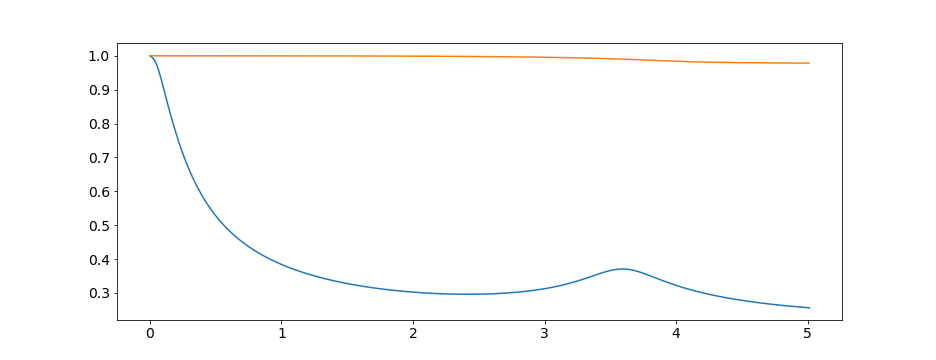

In [60]:
fig, ax = plt.subplots(1,1)

for d in damplist:
    ax.plot(d["time"], d["damping"])
# ax.set_yscale('log')

0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
5      1.000000
6      1.000000
7      1.000000
8      1.000000
9      1.000000
10     1.000000
11     1.000000
12     1.000000
13     1.000000
14     1.000000
15     0.999999
16     0.999999
17     0.999999
18     0.999999
19     0.999999
20     0.999999
21     0.999999
22     0.999999
23     0.999999
24     0.999999
25     0.999999
26     0.999999
27     0.999999
28     0.999999
29     0.999999
         ...   
264    0.987247
265    0.987180
266    0.987109
267    0.987022
268    0.986872
269    0.986745
270    0.986688
271    0.986638
272    0.986592
273    0.986549
274    0.986507
275    0.986467
276    0.986429
277    0.986392
278    0.986357
279    0.986322
280    0.986289
281    0.986256
282    0.986224
283    0.986193
284    0.986163
285    0.986133
286    0.986104
287    0.986076
288    0.986047
289    0.986020
290    0.985993
291    0.985966
292    0.985940
293    0.985914
Name: 2, Length: 294, dt

<IPython.core.display.Javascript object>


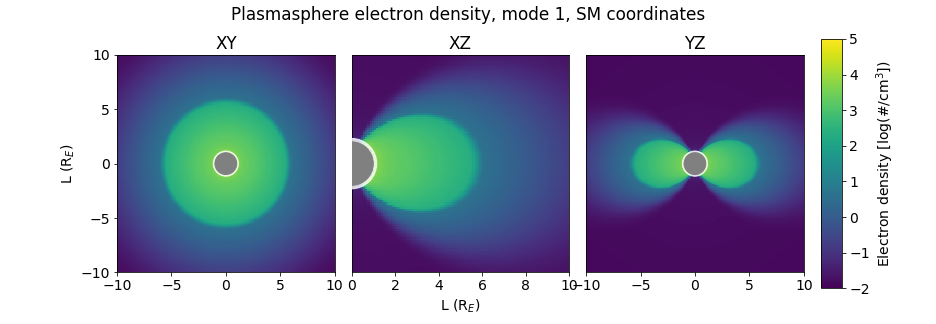

<IPython.core.display.Javascript object>


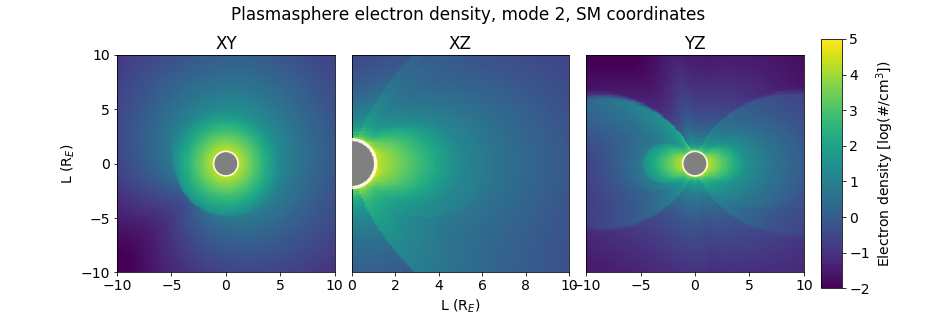

<IPython.core.display.Javascript object>


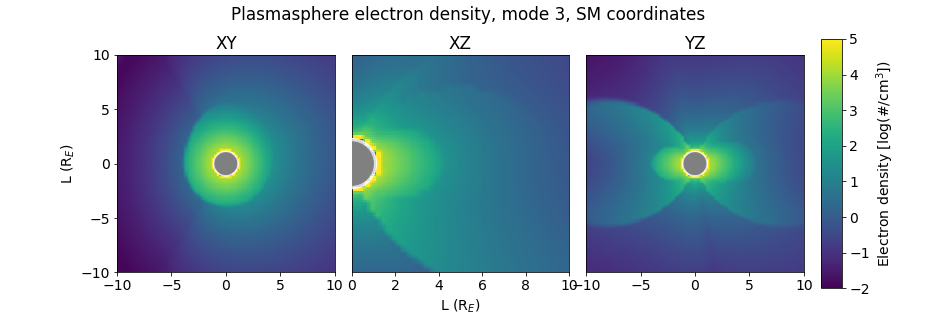

<IPython.core.display.Javascript object>


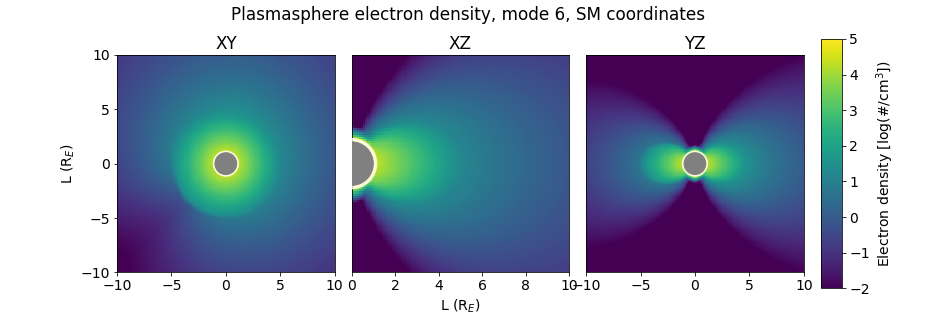

In [68]:
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
fig_width = 12  # width in inches
fig_height = 3.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


# Plot the different plasmasphere models
d = os.listdir(ray_out_dir)
model_files = [x for x in d if x.startswith("model_dump") and x.endswith('.dat')]
modes = np.unique([int(x[16]) for x in model_files])

for mode in modes:
#     fig, ax = plt.subplots(1,3)
    fig = plt.figure()

    gs = gridspec.GridSpec(1,4, width_ratios=[1,1,1,0.1])
    gs.update(wspace=0.1, hspace=0.1) # set the spacing between axes.
    ax = []
    ax.append(plt.subplot(gs[0]))
    ax.append(plt.subplot(gs[1]))
    ax.append(plt.subplot(gs[2]))
    cax = plt.subplot(gs[-1])

    # Load the dumped model files:
    plasma_model_dump = os.path.join(ray_out_dir, 'model_dump_mode_%d_XY.dat'%mode)
    d_xy = readdump(plasma_model_dump)
    plasma_model_dump = os.path.join(ray_out_dir, 'model_dump_mode_%d_XZ.dat'%mode)
    d_xz = readdump(plasma_model_dump)
    plasma_model_dump = os.path.join(ray_out_dir, 'model_dump_mode_%d_YZ.dat'%mode)
    d_yz = readdump(plasma_model_dump)

    # Grab the electron density only 
    #(generally a four-component plasma, but we'll only plot electrons here)
    # Also convert e-/m^3 -> e-/cm^3
    Ne_xy = d_xy['Ns'][0,:,:,:].squeeze().T*1e-6
    Ne_xy[np.isnan(Ne_xy)] = 0
    Ne_xz = d_xz['Ns'][0,:,:,:].squeeze().T*1e-6
    Ne_xz[np.isnan(Ne_xz)] = 0
    Ne_yz = d_yz['Ns'][0,:,:,:].squeeze().T*1e-6
    Ne_yz[np.isnan(Ne_yz)] = 0

    # Axis spacing depends on how the modeldump was ran
    psize = 10
    px = np.linspace(-10, 10, 200)
    py = np.linspace(-10, 10, 200)

    # Colorbar limits (log space)
    clims = [-2, 5]

    # Plot background plasma (equatorial slice)
    p0 = ax[0].pcolormesh(px,py,np.log10(Ne_xy), shading='gourad')
    p0.set_clim(clims)
    p1 = ax[1].pcolormesh(px,py,np.log10(Ne_xz), shading='gourad')
    p1.set_clim(clims)
    p2 = ax[2].pcolormesh(px,py,np.log10(Ne_yz), shading='gourad')
    p2.set_clim(clims)
    
    # Colorbar
    cb = plt.colorbar(p2, cax=cax)
    cb.set_label('Electron density [log(#/cm$^3$])')

    
    

    # Plot the earth
    for i in [0, 1, 2]:
        earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
        iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
        ax[i].add_patch(earth)   
        ax[i].add_patch(iono)

        
        
    # Set limits and tidy up axes
    ax[0].set_title('XY')
    ax[1].set_title('XZ')
    ax[2].set_title('YZ')
    ax[1].set_yticks([])
    ax[2].set_yticks([])

    ax[1].set_xlabel('L (R$_E$)')
    ax[0].set_ylabel('L (R$_E$)')

    ax[0].set_xlim([-psize, psize])
    ax[0].set_ylim([-psize, psize])
    ax[1].set_xlim([0, psize])
    ax[1].set_ylim([-psize/2, psize/2])
    ax[2].set_xlim([-psize, psize])
    ax[2].set_ylim([-psize, psize])

    ax[0].set_aspect('equal')
    ax[1].set_aspect('equal')
    ax[2].set_aspect('equal')

    fig.suptitle('Plasmasphere electron density, mode %d, SM coordinates'%mode)
    fig.savefig(os.path.join(ray_out_dir,'plasmasphere_electron_density_mode_%d.png'%mode))


<IPython.core.display.Javascript object>


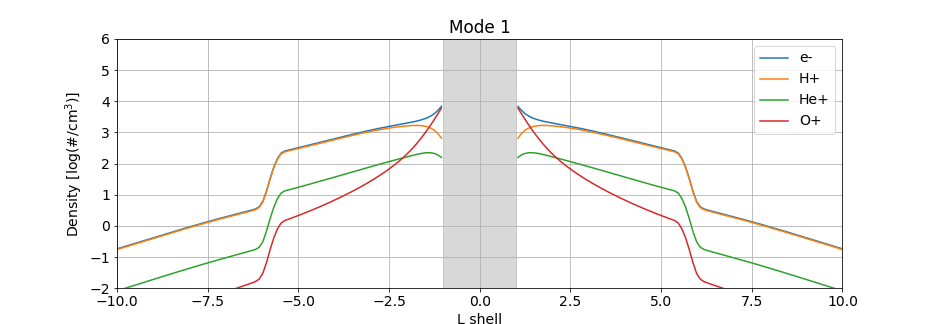

/Users/austin/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


<IPython.core.display.Javascript object>


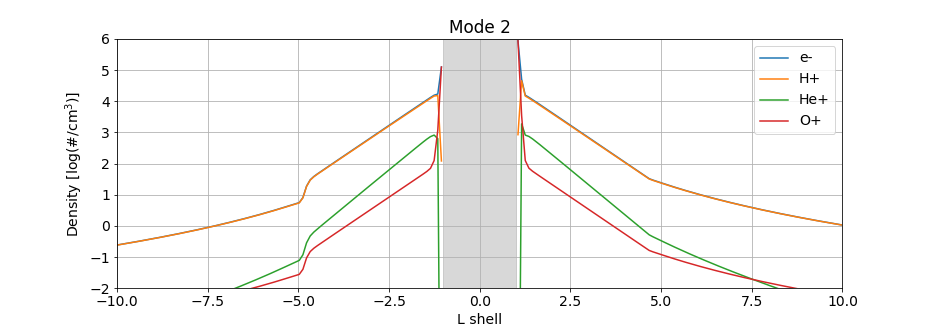

<IPython.core.display.Javascript object>


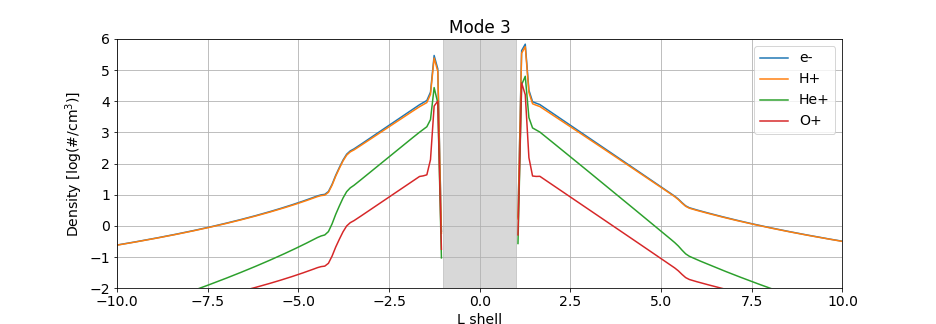

<IPython.core.display.Javascript object>


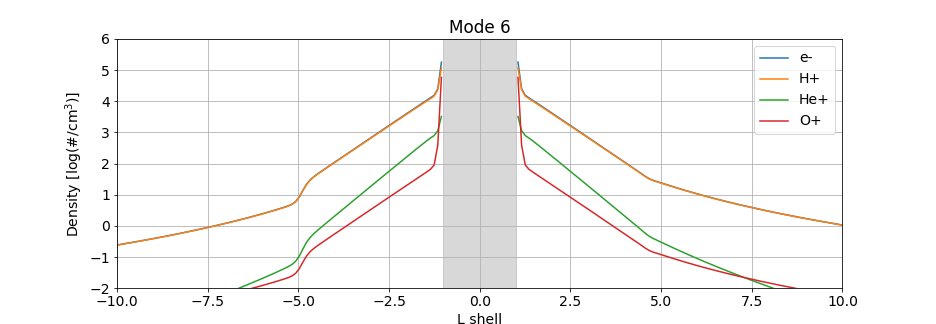

/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [69]:
# Plot model constituent densities along the equator


# fig, ax = plt.subplots(len(modes),1, sharex=True, sharey=True)
# fig, ax = plt.subplots(1,1)

# Line colors for each constituent species
# [e-, H+, He+, O+]
colormap = plt.cm.tab10
species_labels = ['e-','H+','He+','O+']
for index, mode in enumerate(modes):
    fig, ax = plt.subplots(1,1)
    # Load the XY model dump (it's the equatorial-plane slice)
    plasma_model_dump = os.path.join(ray_out_dir, 'model_dump_mode_%d_XY.dat'%mode)
    d_xy = readdump(plasma_model_dump)

    # Modeldump was ran with 200 steps per axis; middle slice is at 100.
    #           [constituent, SM x, SM y, SM z] ~ [4, 200,200,1]
    densities = d_xy['Ns'][:,100,:,:].squeeze().T*1e-6
    
    for element_index in range(4):
        curr_data = np.log10(densities[:,element_index])
        # Some models output values for within the Earth, so let's ignore those.
        curr_data[np.abs(px) < 1] = np.NaN
        ax.plot(px, curr_data, color=colormap(element_index), label = species_labels[element_index])
    
    # Draw a gray box where the Earth would be
    ax.axvspan(-1, 1, alpha=0.3, color='grey')    
    
    ax.set_ylim([-2,6])
    ax.grid('on')
    ax.set_xlim([-10,10])
    ax.set_title('Mode %d'%mode)
    ax.legend()
    ax.set_ylabel('Density [log(#/cm$^3$)]')
    ax.set_xlabel('L shell')

    fig.savefig(os.path.join(ray_out_dir,'plasmasphere_density_lineplot_%d.png'%mode))









(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)